In [3]:
import pymongo
import os
import bson
import json
import glob
import pickle
import gridfs
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.sparse import csr_matrix
from bson.binary import Binary
from os.path import join as opj
from tqdm import notebook
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
import sys

In [30]:
sys.path.append("..")
import dbfind

In [5]:
keyfile = '../6_database/credentials.key'
creds = open(keyfile, "r").read().splitlines()
myclient = pymongo.MongoClient('134.76.24.75', username=creds[0], password=creds[1], authSource='ohol') 
db = myclient.ohol

print(db)
print(db.list_collection_names())

Database(MongoClient(host=['134.76.24.75:27017'], document_class=dict, tz_aware=False, connect=True, authsource='ohol'), 'ohol')
['tfidf_matrix.files', 'maplogs', 'tech_tree', 'lifelogs', 'maplogs_fixed', 'objects', 'expanded_transitions', 'transitions', 'tfidf_matrix.chunks', 'activity_matrix.files', 'activity_matrix.chunks', 'cleaned_job_matrix.chunks', 'cleaned_job_matrix.files', 'activity_labels', 'categories']


## Import activity matrix chunks

In [71]:
# Get pointer from activity_matrix.files
activity_file = list(db.activity_matrix.files.find())
activity_id = activity_file[0]['_id']
print('File metadata:')
print(activity_file)


File metadata:
[{'_id': ObjectId('6085c6c1affb2a7f0bf57a44'), 'uploadDate': datetime.datetime(2021, 4, 25, 19, 48, 18, 502000), 'length': 412799872, 'chunkSize': 261120, 'md5': 'bdcad93c8ef343607e2019d4f188b200'}]


In [72]:
#Load sparse matrix. This takes about 30 seconds
fs = gridfs.GridFS(db, collection='activity_matrix')
activity_bin = fs.get(activity_id)
activity_mtx = pickle.load(activity_bin, encoding='latin1')
print('Loaded activity matrix:')
activity_mtx.shape

Loaded activity matrix:


(763682, 3044)

In [73]:
#Get item and avatar ids
itemIds = db.activity_labels.find_one()['items'] #item ids for each column of the sparse activity matrix
avatarIds = db.activity_labels.find_one()['avatars'] #avatar ids for each row of the sparse activity matrix

### Testing

In [74]:
# #shorten data for testing
# dataLength = 10000
# activity_mtx = activity_mtx[1:dataLength,]
# avatarIds = avatarIds[1:dataLength]
# #Check data sizes
# print(activity_mtx.shape)
# print(len(avatarIds))

### Pre-processing

In [75]:
#Function to delete rows/columns
def delete_from_csr(mat, row_indices=[], col_indices=[]):
    """
    Remove the rows (denoted by ``row_indices``) and columns (denoted by ``col_indices``) from the CSR sparse matrix ``mat``.
    WARNING: Indices of altered axes are reset in the returned matrix
    """
    if not isinstance(mat, csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")

    rows = []
    cols = []
    if row_indices:
        rows = list(row_indices)
    if col_indices:
        cols = list(col_indices)

    if len(rows) > 0 and len(cols) > 0:
        row_mask = np.ones(mat.shape[0], dtype=bool)
        row_mask[rows] = False
        col_mask = np.ones(mat.shape[1], dtype=bool)
        col_mask[cols] = False
        return mat[row_mask][:,col_mask]
    elif len(rows) > 0:
        mask = np.ones(mat.shape[0], dtype=bool)
        mask[rows] = False
        return mat[mask]
    elif len(cols) > 0:
        mask = np.ones(mat.shape[1], dtype=bool)
        mask[cols] = False
        return mat[:,mask]
    else:
        return mat

#### Remove rows (avatars)

In [76]:
#exclusion list for players who didn't make it to adulthood or disconnected
exclusionIds = [q['avatar'] for q in db.lifelogs.find({"$or":[ {"age":{"$lt":14}}, {"cause_of_death":'disconnected'}]}, {'avatar'})]
len(exclusionIds) #note, not all overlapping with the ids in the activity matrix, since many of these never generated any map change data

627018

In [77]:
#Find the ids (rows in sparse activity_mtx) to delete
deleteIds = np.nonzero(np.in1d(avatarIds,exclusionIds))[0]
len(deleteIds)

101256

In [78]:
#Delete excluded avatars
activity_mtx = delete_from_csr(activity_mtx, row_indices = deleteIds.tolist())
for index in sorted(deleteIds.tolist(), reverse=True):
    del avatarIds[index]

In [79]:
#Check that all data is the right shape
print(activity_mtx.shape)
print(len(avatarIds))

(662426, 3044)
662426


#### Remove columns (items)

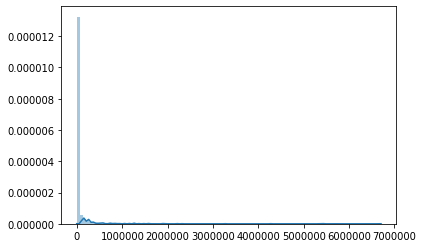

In [80]:
#look at distribution
sns.distplot(activity_mtx.sum(axis = 0), bins = 100) #histrogram of item iteractions

In [81]:
#Which items to dete
deleteIds = np.where(activity_mtx.sum(axis = 0)==0)[1]
len(deleteIds)

0

In [82]:
#Delete excluded items
activity_mtx = delete_from_csr(activity_mtx, col_indices = deleteIds.tolist())
for index in sorted(deleteIds.tolist(), reverse=True):
    del itemIds[index]

In [83]:
print(activity_mtx.shape)
print(len(itemIds))

(662426, 3044)
3044


#### Finished preprocessing

In [84]:
jobMatrixCleaned = activity_mtx

In [85]:
cleanedDict = {'mat' : jobMatrixCleaned, 
            'items' : itemIds,
            'avatars': avatarIds}

In [86]:
#Save on database
fs = gridfs.GridFS(db, collection='cleaned_job_matrix')
fs.put(Binary(pickle.dumps(cleanedDict, protocol=2), subtype=128))

ObjectId('60884966960517b5ced2e75d')

### TF-IDF normalization

In [87]:
#Load cleaned matrix. This takes about 30 seconds
mat_id = list(db.cleaned_job_matrix.files.find())[0]['_id'] #get id
fs = gridfs.GridFS(db, collection='cleaned_job_matrix') 
mat_bin = fs.get(mat_id) #extract binary
mat_dict = pickle.load(mat_bin, encoding='latin1')
jobMatrixCleaned = mat_dict['mat']
itemIds = mat_dict['items']
avatarIds = mat_dict['avatars']
print('Loaded Job matrix:')
jobMatrixCleaned.shape

EOFError: Ran out of input

In [19]:
# # test using old, ineffecient method
# jobMatrixCleaned = jobMatrixCleaned.toarray()
# #Term frequency: let's use augmented frequency, which prevents a bias towards longer documents (i.e., players who have many item interactions)
# def tf(avatarVec):
#     return(0.5 + ((0.5* avatarVec) / max(avatarVec)))

# #inverse document frequency:
# def idf(itemVec):
#     return(np.log(sum(itemVec)/len(itemVec[itemVec>0])))

# #compute tf and idf mats
# tfMat = np.ones(jobMatrixCleaned.shape)
# for row in range(jobMatrixCleaned.shape[0]):
#     tfMat[row,:] = tf(jobMatrixCleaned[row,:]) 
# idfMat = np.ones(jobMatrixCleaned.shape)
# for col in range(jobMatrixCleaned.shape[1]):
#     idfMat[:,col] = idf(jobMatrixCleaned[:,col]) 
# tfIdfMat = tfMat * idfMat

# tfidfJobMatrix = tfIdfMat * jobMatrixCleaned #now compute tfidf

# row_sums = tfidfJobMatrix.sum(axis=1)
# tfidfJobMatrixNormalized = tfidfJobMatrix / row_sums[:, np.newaxis]
# tfidfJobMatrixNormalized = np.nan_to_num(tfidfJobMatrixNormalized)

In [20]:
#Term frequency: let's use augmented frequency, which prevents a bias towards longer documents (i.e., players who have many item interactions)
#Each row vector v undergoes the following transformation:  tf(v) = 0.5 + (0.5*v)/(max(v))
TF = jobMatrixCleaned.toarray() #convert to array
TF = TF/jobMatrixCleaned.max(axis=1).toarray() #divide by max
TF *= 0.5 
TF += 0.5

In [21]:
#TODO: Some funny negative elements
#Inverse document frequency
#np.log(sum(itemVec)/len(itemVec[itemVec>0]))
IDFcolsums = jobMatrixCleaned.sum(axis = 0)
nonNegCounts = Counter(jobMatrixCleaned.nonzero()[1]) #Count non-negative elements in each column
nonNeg = np.ones(jobMatrixCleaned.shape[1])
nonNeg[list(nonNegCounts.keys())] = list(nonNegCounts.values())
IDF = np.log(IDFcolsums / nonNeg)

In [22]:
#Multiply together
tfIdfMat = np.multiply(TF, IDF)

In [23]:
tfidfJobMatrix = jobMatrixCleaned.multiply(tfIdfMat)  #now compute tfidf

In [24]:
tfidfJobMatrix

<662426x3044 sparse matrix of type '<class 'numpy.float64'>'
	with 33354803 stored elements in COOrdinate format>

In [35]:
#Normalized rows
tfidfJobMatrixNormalized = normalize(tfidfJobMatrix, norm='l1', axis=1)

In [51]:
tfidfDict = {'mat' : tfidfJobMatrixNormalized, 
            'items' : itemIds,
            'avatars': avatarIds}

In [55]:
#Save on database
# fs = gridfs.GridFS(db, collection='tfidf_matrix')
# fs.put(Binary(pickle.dumps(tfidfDict, protocol=2), subtype=128))

ObjectId('608846da960517b5ced2defe')

## Non-negative matrix factorization

### Load data

In [45]:
#Load tfidf matrix. This takes about 30 seconds
# mat_id = list(db.tfidf_matrix.files.find())[0]['_id'] #get id
# fs = gridfs.GridFS(db, collection='tfidf_matrix') 
# mat_bin = fs.get(mat_id) #extract binary
# mat_dict = pickle.load(activity_bin, encoding='latin1')
# tfidfJobMatrixNormalized = mat_dict['mat']
# itemIds = mat_dict['items']
# avatarIds = mat_dict['avatars']
# print('Loaded Job matrix:')
# tfidfJobMatrixNormalized.shape

Loaded Job matrix:


(662426, 3044)

In [7]:
#Load cleaned matrix. This takes about 30 seconds
mat_id = list(db.cleaned_job_matrix.files.find())[0]['_id'] #get id
fs = gridfs.GridFS(db, collection='cleaned_job_matrix') 
mat_bin = fs.get(mat_id) #extract binary
mat_dict = pickle.load(mat_bin, encoding='latin1')
jobMatrixCleaned = mat_dict['mat']
itemIds = mat_dict['items']
avatarIds = mat_dict['avatars']
print('Loaded Job matrix:')
jobMatrixCleaned.shape

Loaded Job matrix:


(662426, 3044)

### Fit Model

In [17]:
#Fit model
model = NMF(n_components=20, init='random', random_state=0)
W = model.fit_transform(jobMatrixCleaned) #cleaned matrix (row normalized)
#W = model.fit_transform(tfidfJobMatrixNormalized) #TFIDF transformed matrix
H = model.components_
#TODO: Save W and H matrices somewhere

### Save/load outputs

In [28]:
#Save outputs
Hdict = [{'item':itemIds[i], 'vec':H[:,i].tolist()} for i in range(len(itemIds))] #Item embeddings
Wdict = [{'avatar':avatarIds[i], 'vec':W[i,:].tolist()} for i in range(len(avatarIds))] #avatar embeddings

In [29]:
db.item_embeddings.insert_many(Hdict)
db.avatar_embeddings.insert_many(Wdict)

In [37]:
#Load and reconstruct

In [ ]:
db.item_embeddings.find()

Text(0.5, 69.0, 'Item')

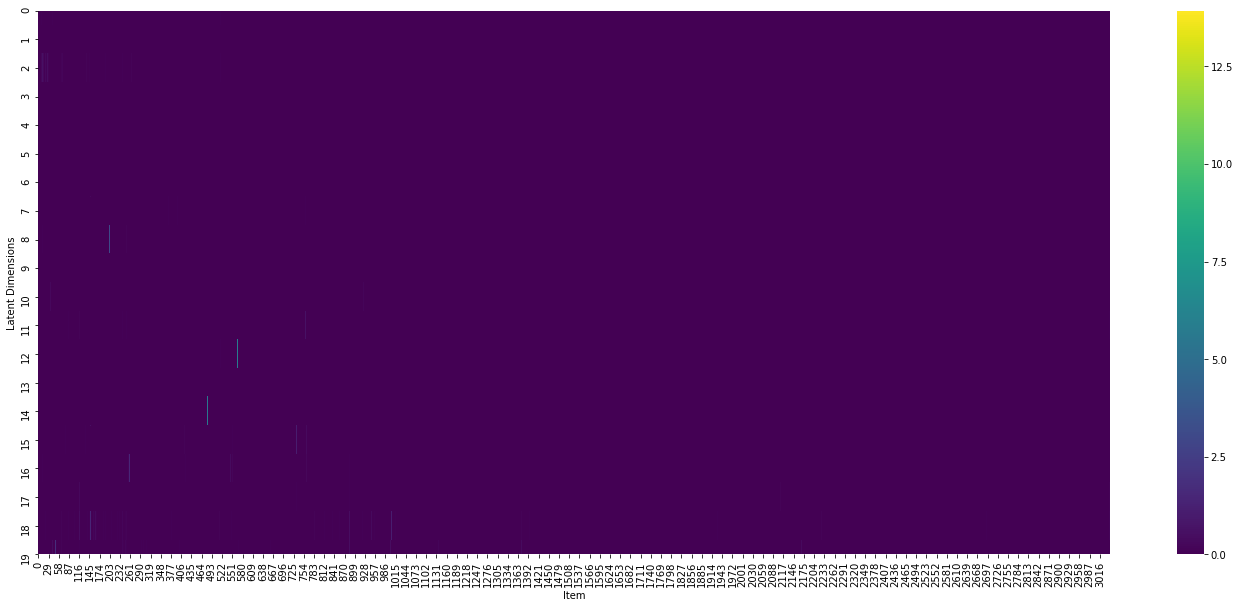

In [9]:
#How well can we allocate items to different latent dimensions?
plt.figure(figsize=(24, 10))
ax = sns.heatmap(H,  cmap="viridis") #x-axis are unique items and y-axis are the loadings
ax.set_ylabel('Latent Dimensions')
ax.set_xlabel('Item')

(array([3., 4., 5., 2., 3., 1., 1., 0., 0., 1.]),
 array([2.44381954e-02, 2.98185803e+00, 5.93927786e+00, 8.89669770e+00,
        1.18541175e+01, 1.48115374e+01, 1.77689572e+01, 2.07263770e+01,
        2.36837969e+01, 2.66412167e+01, 2.95986365e+01]),
 <a list of 10 Patch objects>)

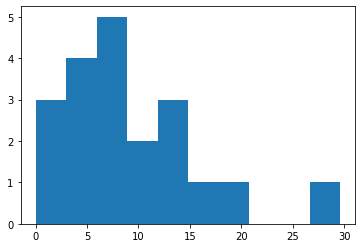

In [10]:
#What is the distribution of total loadings across items?
plt.hist(H.sum(axis = 1))

In [11]:
#Which items most strongly defined each component?
for C in range(H.shape[0]):
    comp = H[C,] #component
    items = comp.argsort()[-5:][::-1]#sort by weight; select the top 5 items
    print(C)
    for item in items:
        try:
            objname = dbfind.item(itemIds[item])[0][0] #relate to item id using the trimmed_idx, and then look up
            weight = str(comp[item])
            print(' : '.join([objname, weight]))
        except:
            print(' : '.join([str(int(item)), str(comp[item])]))
    print('')


0
Fresh Grave - origGrave fromDeath : 4.2928382589779055
Gooseberry : 0.07998999310074442
Large Slow Fire : 0.0721470602848995
Pine Needles : 0.06195150315283329
Juniper Tree : 0.05981061124881037

1
Baby Bone Pile - origGrave justDied fromDeath : 13.92701897565167
Reed Skirt : 0.011712676017880121
Sheep Skin : 0.00876472948903939
Undyed Button-down Shirt : 0.007261020330500999
Ghost Costume : 0.006453126500676567

2
Straight Branch : 2.5172174089697004
Long Straight Shaft : 1.8429405386548536
Maple Tree : 1.0605633341628324
Kindling : 0.7672167793305401
Milkweed Stalk : 0.6951826583485332

3
Fresh Grave - origGrave fromDeath : 8.333751605154315
Backpack : 0.016800400838356922
Heat Stroke - sick emot_21_60 : 0.005622388612050763
Reed Skirt : 0.0044139478943911
Dehydration - sick emot_20_60 : 0.003171553874049815

4
Baby Bone Pile - origGrave justDied fromDeath : 11.987305538695601
Rubber Ball - bouncing : 0.001425357005659807
Undyed Bowler Hat with Feather : 0.0006090657784156708
Undye

## Interpreting avatar embeddings

Text(195.0, 0.5, 'Avatar')

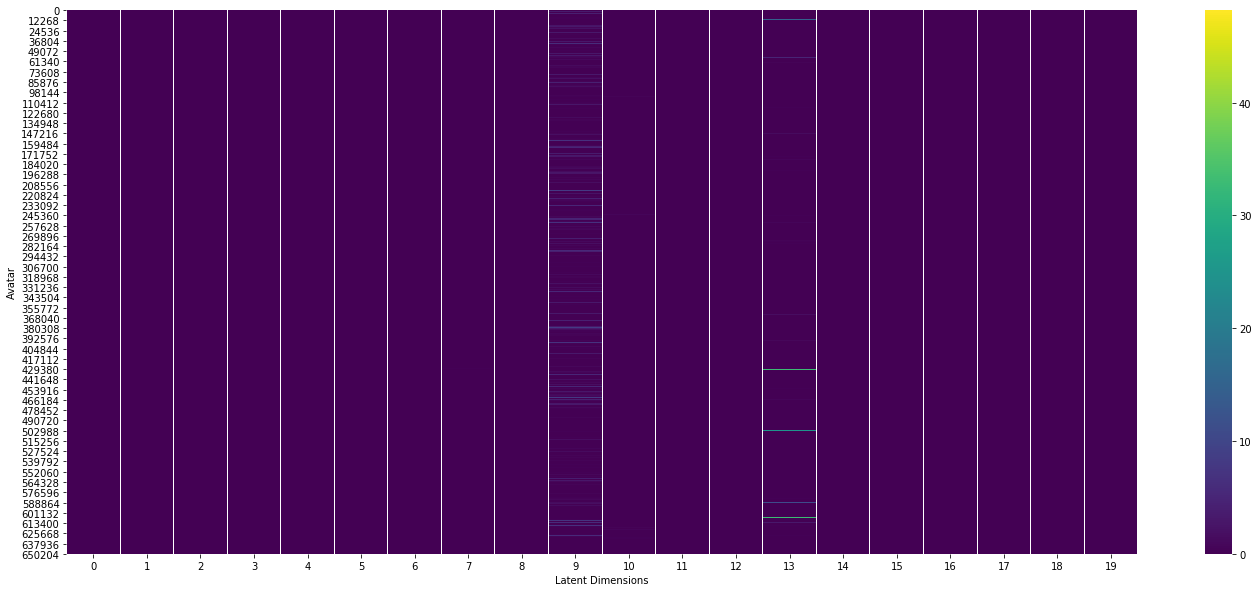

In [12]:
plt.figure(figsize=(24, 10))
ax = sns.heatmap(W,  cmap="viridis") 
ax.set_xlabel('Latent Dimensions')
ax.set_ylabel('Avatar')

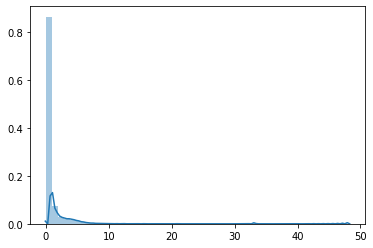

In [14]:
#Sum of loadings 
#The magnitude of the embedding vector for each player tells us how confidently we are able to assign that player to the latent space. 
sns.distplot(W.sum(axis = 1)) 

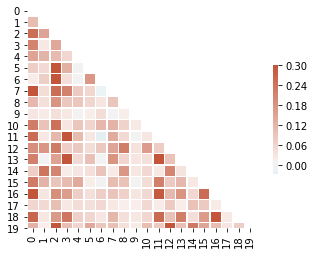

In [94]:
#How correlated are the latent embedding dimensions?
corr = pd.DataFrame(W).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))


# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [95]:
#PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(W)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


In [96]:
print(pca.explained_variance_) #not very much

[2.03216802 0.54426478]


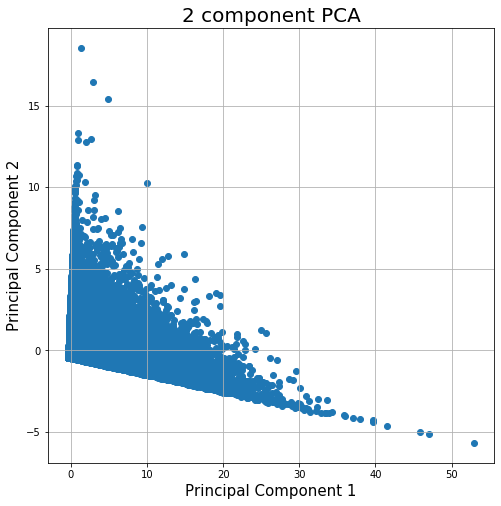

In [97]:
#Job space embeddings
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
ax.scatter(principalDf['principal component 1'],principalDf['principal component 2'])
ax.grid()

## Compare with other player data

In [63]:
#Can we relate the magnitude of the embedding to other characteristics?
playerDF['totalLoading'] = W.sum(axis = 1)
sns.jointplot(data=playerDF, x='n_life', y = 'totalLoading', kind = 'reg') #alternative can look at 'age', 'gen', etc...
plt.show()

NameError: name 'playerDF' is not defined

In [ ]:
#add latent dimensions
jobDF = playerDF
for i in range(20):
    jobDF['Dim'+str(i)] = W[:,i]